In [1]:
import sys
import os

# Add the parent directory (project root) to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from general_python import algebra

=== Backend Initialization ===
	NumPy Version: 1.26.4
	SciPy Version: 1.13.1
	JAX Version: 2023.12
	Active Backend: jax
	JAX Available: True
	Default Random Key: [    0 12345]
	Active Backend Modules:
		  Main Module: <module 'jax.numpy' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/numpy/__init__.py'>
		  Random Module: <module 'jax.random' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/random.py'>
		  SciPy Module: <module 'jax.scipy' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/scipy/__init__.py'>
=== End of Backend Info ===


# Models

## Quantum Sun Model

In [1]:
from Algebra.Model.Interacting.Spin.qsm import QSM

qsm=QSM(ns=9, hilbert_space=None, n=3, a=0.8, h=1.0, xi=0.2, backend = 'jax', dtype='float64')
qsm

=== Backend Initialization ===
	NumPy Version: 1.26.4
	SciPy Version: 1.13.1
	JAX Version: 2023.12
	Active Backend: jax
	JAX Available: True
	Default Random Key: [    0 12345]
	Active Backend Modules:
		  Main Module: <module 'jax.numpy' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/numpy/__init__.py'>
		  Random Module: <module 'jax.random' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/random.py'>
		  SciPy Module: <module 'jax.scipy' from '/Users/makskliczkowski/miniconda3/lib/python3.12/site-packages/jax/scipy/__init__.py'>
=== End of Backend Info ===


01_03_2025_12-52_57 [INFO] Log file created: ./log/global.log
01_03_2025_12-52_57 [INFO] Log level set to: info
01_03_2025_12-52_57 [INFO] ########### Global logger initialized. ###########
01_03_2025_12-52_57 [INFO] 	->[HilbertSpace] No local or global symmetries provided; symmetry group is empty.
01_03_2025_12-52_57 [INFO] 	->[HilbertSpace] No mapping generated.
01_03_2025_12-52_57 [INFO] 	->[Quantum Sun Model] alpha = [0.800, 0.800, 0.800, 0.800, 0.800, 0.800]
01_03_2025_12-52_57 [INFO] 		->[Quantum Sun Model] u = [1.000, 0.857, 1.822, 3.151, 3.844, 4.940]
01_03_2025_12-52_57 [INFO] 		->[Quantum Sun Model] alpha^u = [0.800, 0.826, 0.666, 0.495, 0.424, 0.332]
01_03_2025_12-52_58 [INFO] 		->[Quantum Sun Model] H_dot norm: 1.761e+00


,qsm,Ns=9,N=3,gamm=1.00,g0=1.00,alpha=0.800,h=1.000,xi=0.200

#### Build

##### Sparse

In [2]:
qsm.build(verbose=True, use_numpy=True)

01_03_2025_12-53_00 [INFO] 	->[Quantum Sun Model] Building the Hamiltonian matrix...
01_03_2025_12-53_00 [INFO] 		->[Quantum Sun Model] Initializing the Hamiltonian matrix...
01_03_2025_12-53_00 [INFO] 			->[Quantum Sun Model] JAX is available but NumPy is forced...
01_03_2025_12-53_00 [INFO] 			->[Quantum Sun Model] Initializing the Hamiltonian matrix as a sparse matrix...
01_03_2025_12-53_00 [INFO] 			->[Quantum Sun Model] Initializing the Hamiltonian matrix as a CSR sparse matrix...
01_03_2025_12-53_00 [INFO] 			->[Quantum Sun Model] Hamiltonian matrix initialized.
01_03_2025_12-53_00 [INFO] 		->[Quantum Sun Model] Initialization completed in 0.002050 seconds
01_03_2025_12-53_00 [INFO] 		->[Quantum Sun Model] QSM: alpha=0.800, xi=0.200
01_03_2025_12-53_00 [INFO] 			->[Quantum Sun Model] QSM: i=0 -> h=1.000e+00, a^u=8.000e-01
01_03_2025_12-53_00 [INFO] 			->[Quantum Sun Model] QSM: i=1 -> h=1.000e+00, a^u=8.260e-01
01_03_2025_12-53_00 [INFO] 			->[Quantum Sun Model] QSM: i=2 -> h=1.0

In [3]:
qsm.memory_gb

01_03_2025_12-53_03 [INFO] 	->[Quantum Sun Model] Checking the memory used by the Hamiltonian matrix of type <class 'scipy.sparse._csr.csr_matrix'>
01_03_2025_12-53_03 [INFO] 		->[Quantum Sun Model] It is not a dense matrix...


8.0108642578125e-05

In [4]:
qsm.diagonalize(verbose=True)

01_03_2025_12-53_04 [INFO] [Quantum Sun Model] Diagonalization (standard) completed in 0.088146 seconds.


##### Dense

In [5]:
qsm.to_dense()

01_03_2025_12-53_06 [INFO] 	->[Quantum Sun Model] Converting the Hamiltonian matrix to a dense matrix... Run build...
01_03_2025_12-53_06 [INFO] 		->[Quantum Sun Model] Hamiltonian cleared...


In [6]:
qsm.build(verbose=True, use_numpy=True)

01_03_2025_12-53_09 [INFO] 	->[Quantum Sun Model] Building the Hamiltonian matrix...
01_03_2025_12-53_09 [INFO] 		->[Quantum Sun Model] Initializing the Hamiltonian matrix...
01_03_2025_12-53_09 [INFO] 			->[Quantum Sun Model] JAX is available but NumPy is forced...
01_03_2025_12-53_09 [INFO] 			->[Quantum Sun Model] Initializing the Hamiltonian matrix as a dense matrix...
01_03_2025_12-53_09 [INFO] 			->[Quantum Sun Model] Hamiltonian matrix initialized.
01_03_2025_12-53_09 [INFO] 		->[Quantum Sun Model] Initialization completed in 0.001956 seconds
01_03_2025_12-53_09 [INFO] 		->[Quantum Sun Model] QSM: alpha=0.800, xi=0.200
01_03_2025_12-53_09 [INFO] 			->[Quantum Sun Model] QSM: i=0 -> h=1.000e+00, a^u=8.000e-01
01_03_2025_12-53_09 [INFO] 			->[Quantum Sun Model] QSM: i=1 -> h=1.000e+00, a^u=8.260e-01
01_03_2025_12-53_09 [INFO] 			->[Quantum Sun Model] QSM: i=2 -> h=1.000e+00, a^u=6.659e-01
01_03_2025_12-53_09 [INFO] 			->[Quantum Sun Model] QSM: i=3 -> h=1.000e+00, a^u=4.951e-01
01

In [7]:
qsm.diagonalize(verbose=True)

01_03_2025_12-53_12 [INFO] [Quantum Sun Model] Diagonalization (standard) completed in 0.190281 seconds.


In [8]:
qsm.h_memory_gb

01_03_2025_12-53_16 [INFO] 	->[Quantum Sun Model] Checking the memory used by the Hamiltonian matrix of type <class 'numpy.matrix'>


0.001953125

##### Plot tests

(array([-3.85803194e+00, -3.65079666e+00, -3.40773599e+00, -3.24452963e+00,
        -3.04086814e+00, -3.02166213e+00, -2.86740651e+00, -2.84814573e+00,
        -2.83858731e+00, -2.83542566e+00, -2.81439586e+00, -2.77151833e+00,
        -2.67099219e+00, -2.64021803e+00, -2.63033748e+00, -2.62077514e+00,
        -2.60457999e+00, -2.57429654e+00, -2.56132332e+00, -2.41828482e+00,
        -2.38644453e+00, -2.38003357e+00, -2.36541260e+00, -2.34168164e+00,
        -2.31305566e+00, -2.28729825e+00, -2.23031537e+00, -2.22055493e+00,
        -2.21168110e+00, -2.19193654e+00, -2.16515923e+00, -2.07109368e+00,
        -2.03285210e+00, -2.02231144e+00, -2.01741659e+00, -2.00513058e+00,
        -2.00243869e+00, -1.99141086e+00, -1.98466387e+00, -1.95426764e+00,
        -1.94659007e+00, -1.93707604e+00, -1.90070636e+00, -1.88934184e+00,
        -1.85566590e+00, -1.83329706e+00, -1.82958555e+00, -1.82683650e+00,
        -1.82359445e+00, -1.81014889e+00, -1.80416635e+00, -1.79817946e+00,
        -1.7

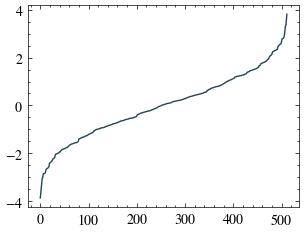

In [9]:
import matplotlib.pyplot as plt
plt.plot(qsm.eig_val)
qsm.eig_val, qsm.eig_vec, qsm.eig_vec.shape

Minimum value: -3.36565635001652
Maximum value: 3.2832581112856243


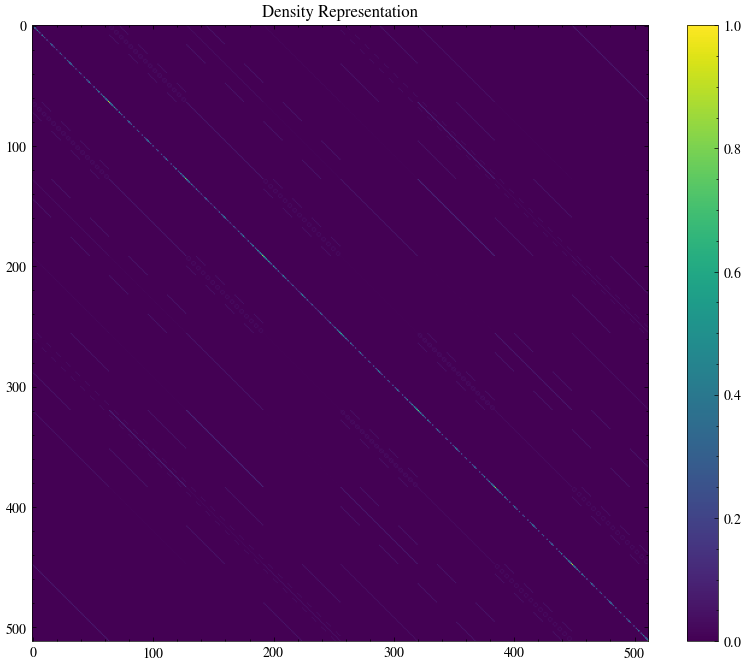

In [11]:
import numpy as np
# make dense
qsm_dense   = qsm.hamil.todense() if qsm.sparse else qsm.hamil
minimum     = qsm_dense.min()
maximum     = qsm_dense.max()
qsm_dense   = np.abs(qsm_dense) / np.abs(qsm_dense).max()

print("Minimum value:", minimum)
print("Maximum value:", maximum)

plt.figure(figsize=(10, 8))
plt.imshow(qsm_dense, cmap='viridis')
plt.colorbar()
plt.title("Density Representation")
plt.show()

# Linear algebra

In [ ]:
a = algebra.AlgebraTests(backend='jax')
b = algebra.AlgebraTests(backend='numpy')

NameError: name 'algebra' is not defined

## Standard tests

### Change the basis with a unitary matrix

In [ ]:
a.change_basis(verbose=True)
b.change_basis(verbose=True)

[14/02/2025 02:19:50]	->[TEST 1] Starting change_basis
U=


Matrix([
[0, 1],
[1, 0]])

vec=


Matrix([
[1],
[0]])

tvec=


Matrix([
[0],
[1]])

transformed_vec=


Matrix([
[0],
[1]])

transformed_twice=


Matrix([
[1],
[0]])

[14/02/2025 02:19:50]	->[TEST 1] Completed change_basis
[14/02/2025 02:19:50]	->[TEST 1] Starting change_basis
U=


Matrix([
[0, 1],
[1, 0]])

vec=


Matrix([
[1],
[0]])

tvec=


Matrix([
[0],
[1]])

transformed_vec=


Matrix([
[0],
[1]])

transformed_twice=


Matrix([
[1],
[0]])

[14/02/2025 02:19:50]	->[TEST 1] Completed change_basis


### Change the basis of a matrix with a unitary matrix

In [ ]:
a.change_basis_matrix(verbose=True)

[14/02/2025 02:19:55]	->[TEST 2] Starting change_basis_matrix
U=


Matrix([
[0, 1],
[1, 0]])

A=


Matrix([
[1, 2],
[3, 4]])

At=


Matrix([
[4, 3],
[2, 1]])

transformed_matrix=


Matrix([
[4, 3],
[2, 1]])

[14/02/2025 02:19:55]	->[TEST 2] Completed change_basis_matrix


### Outer product

In [ ]:
a.outer(verbose=True)
b.outer(verbose=True)

[14/02/2025 02:19:57]	->[TEST 3] Starting outer
A=


Matrix([
[1],
[2]])

B=


Matrix([
[3],
[4]])

outer_product= A ⊗ B


Matrix([
[3, 4],
[6, 8]])

A_mat=


Matrix([
[1, 2],
[2, 0]])

B_mat=


Matrix([
[3, 4],
[4, 0]])

outer_product_mat= A_mat ⊗ B_mat


Matrix([
[3, 4, 4, 0],
[6, 8, 8, 0],
[6, 8, 8, 0],
[0, 0, 0, 0]])

[14/02/2025 02:19:57]	->[TEST 3] Completed outer
[14/02/2025 02:19:57]	->[TEST 3] Starting outer
A=


Matrix([
[1],
[2]])

B=


Matrix([
[3],
[4]])

outer_product= A ⊗ B


Matrix([
[3, 4],
[6, 8]])

A_mat=


Matrix([
[1, 2],
[2, 0]])

B_mat=


Matrix([
[3, 4],
[4, 0]])

outer_product_mat= A_mat ⊗ B_mat


Matrix([
[3, 4, 4, 0],
[6, 8, 8, 0],
[6, 8, 8, 0],
[0, 0, 0, 0]])

[14/02/2025 02:19:57]	->[TEST 3] Completed outer


### Kronecker product

In [ ]:
a.kron(verbose=True)

[10/02/2025 19:49:28]	->[TEST 4] Starting kron
A=


Matrix([
[1, 2],
[3, 4]])

B=


Matrix([
[5, 6],
[7, 8]])

kron_product= A ⊗ B


Matrix([
[ 5,  6, 10, 12],
[ 7,  8, 14, 16],
[15, 18, 20, 24],
[21, 24, 28, 32]])

[10/02/2025 19:49:28]	->[TEST 4] Completed kron


## Linear solvers

In [ ]:
a = algebra.SolversTests(backend='numpy')
b = algebra.SolversTests(backend='jax')

In [ ]:
a.solver_test()

[TEST 0] Starting solver test using cg


TypeError: random() got an unexpected keyword argument 'dtype'

# Binary 

### Standard tests

In [ ]:
from general_python.common import binary
NUM         = 42
tests       = binary.BinaryFunctionTests()

In [ ]:
tests.run_tests(NUM, spin_value = binary._BACKENDREPR)

[14/02/2025 02:22:22]	->[TEST 0] ==================================================
[14/02/2025 02:22:22]	->[TEST 0]              TESTING BINARY FUNCTIONS             
[14/02/2025 02:22:22]	->[TEST 0] ==================================================
[14/02/2025 02:22:22]	->[TEST 0] Random integer n = 304487426887 (binary: 000100011011100100110111010110101101000111)
[14/02/2025 02:22:22]	->[TEST 0] --------------------------------------------------
[14/02/2025 02:22:22]	->[TEST 0] --------------------------------------------------
[14/02/2025 02:22:22]	->[TEST 1] Test 1: Extract bits using mask
[14/02/2025 02:22:22]	->[TEST 1] Input n    : 000100011011100100110111010110101101000111
[14/02/2025 02:22:22]	->[TEST 1] Mask       : 000000000000000000000000000000000000001011
[14/02/2025 02:22:22]	->[TEST 1] Extracted  : 000000000000000000000000000000000000000011 (3)
[14/02/2025 02:22:22]	->[TEST 1] Time       : 0.000002 seconds
[14/02/2025 02:22:22]	->[TEST 1] ------------------------------

In [ ]:
tests.run_tests(NUM, spin_value = binary._BACKENDREPR, backend = 'np')

[14/02/2025 02:22:28]	->[TEST 0] ==================================================
[14/02/2025 02:22:28]	->[TEST 0]              TESTING BINARY FUNCTIONS             
[14/02/2025 02:22:28]	->[TEST 0] ==================================================
[14/02/2025 02:22:28]	->[TEST 0] Random integer n = 463308285429 (binary: 000110101111011111010100110110010111110101)
[14/02/2025 02:22:28]	->[TEST 0] --------------------------------------------------
[14/02/2025 02:22:28]	->[TEST 0] --------------------------------------------------
[14/02/2025 02:22:28]	->[TEST 1] Test 1: Extract bits using mask
[14/02/2025 02:22:28]	->[TEST 1] Input n    : 000110101111011111010100110110010111110101
[14/02/2025 02:22:28]	->[TEST 1] Mask       : 000000000000000000000000000000000000001011
[14/02/2025 02:22:28]	->[TEST 1] Extracted  : 000000000000000000000000000000000000000001 (1)
[14/02/2025 02:22:28]	->[TEST 1] Time       : 0.000004 seconds
[14/02/2025 02:22:28]	->[TEST 1] ------------------------------

### Test JAX

In [ ]:
from algebra import get_backend
import time 
from jax import numpy as jnp, random as jnpr
import numpy as np, numpy.random as npr
from jax import jit

seed = 1701

# Test the speed of the matrix multiplication
key_np = npr.seed(seed)
key_jnp = jnpr.key(seed)
size = 5000

def matrix_mult_test_jax(size=size):
    random_mat  = jnpr.normal(key_jnp, (size, size))
    vec         = jnpr.normal(key_jnp, (size,))
    result      = random_mat @ vec
    print("Result of matrix-vector multiplication:\n", result)
    
def matrix_mult_test_numpy(size = size):
    random_mat  = npr.normal(size=(size, size))
    vec         = npr.normal(size=(size,))
    result      = random_mat @ vec
    print("Result of matrix-vector multiplication:\n", result)
    
@jit
def matrix_mult_test_jax_jit():
    random_mat  = jnpr.normal(key_jnp, (size, size))
    vec         = jnpr.normal(key_jnp, (size,))
    result      = random_mat @ vec
    print("Result of matrix-vector multiplication:\n", result)


#### Numpy

In [ ]:
start_time = time.time()
matrix_mult_test_numpy()
end_time = time.time()
print(f"Time taken: {end_time - start_time:.4f} seconds (numpy)")

Result of matrix-vector multiplication:
 [ -8.88432611  21.0377515  -48.17831994 ...  55.97818048  59.8701578
  -4.3396083 ]
Time taken: 0.5076 seconds (numpy)


#### Jax

In [ ]:
start_time = time.time()
matrix_mult_test_jax()
end_time = time.time()
print(f"Time taken: {end_time - start_time:.4f} seconds (jax)")

Result of matrix-vector multiplication:
 [ 36.282516   22.475544   -1.3575363 ...  41.09931    -3.48946
 -64.0355   ]
Time taken: 0.0888 seconds (jax)


#### Jax jit

In [ ]:
start_time = time.time()
matrix_mult_test_jax_jit()
end_time = time.time()  
print(f"Time taken: {end_time - start_time:.4f} seconds (jax, jitted)")

Result of matrix-vector multiplication:
 Traced<ShapedArray(float32[5000])>with<DynamicJaxprTrace(level=1/0)>
Time taken: 0.0180 seconds (jax, jitted)


# Lattice


In [ ]:
from lattices import Lattice, run_lattice_tests

# Run tests for different configurations
# run_lattice_tests(dim=1, lx=10, ly=1, lz=1, bc=lattices.LatticeBC.PBC, typek="square")
# run_lattice_tests(dim=2, lx=5, ly=3, lz=1, bc=lattices.LatticeBC.PBC, typek="square")
# run_lattice_tests(dim=2, lx=5, ly=5, lz=1, bc=lattices.LatticeBC.OBC, typek="square")
# run_lattice_tests(dim=3, lx=3, ly=3, lz=3, bc=lattices.LatticeBC.PBC, typek="square")
run_lattice_tests(dim=2, lx=3, ly=2, lz=1, bc=lattices.LatticeBC.PBC, typek="honeycomb")


KeyboardInterrupt



0.0 0.0
Ns= 0 -- (x,y)= 0 0
0.8660254037844386 0.5
Ns= 1 -- (x,y)= 0 0
1.7320508075688772 0.0
Ns= 2 -- (x,y)= 1 0
2.598076211353316 0.5
Ns= 3 -- (x,y)= 1 0
3.4641016151377544 0.0
Ns= 4 -- (x,y)= 2 0
6.06217782649107 0.5
Ns= 5 -- (x,y)= 2 0
5.196152422706632 0.0
Ns= 6 -- (x,y)= 3 0
11.258330249197702 0.5
Ns= 7 -- (x,y)= 3 0
0.8660254037844386 1.5
Ns= 8 -- (x,y)= 0 1
12.12435565298214 2.0
Ns= 9 -- (x,y)= 0 1
2.598076211353316 1.5
Ns= 10 -- (x,y)= 1 1
14.722431864335457 3.5
Ns= 11 -- (x,y)= 1 1
4.330127018922193 1.5
Ns= 12 -- (x,y)= 2 1
19.05255888325765 5.0
Ns= 13 -- (x,y)= 2 1
6.06217782649107 1.5
Ns= 14 -- (x,y)= 3 1
25.11473670974872 6.5
Ns= 15 -- (x,y)= 3 1


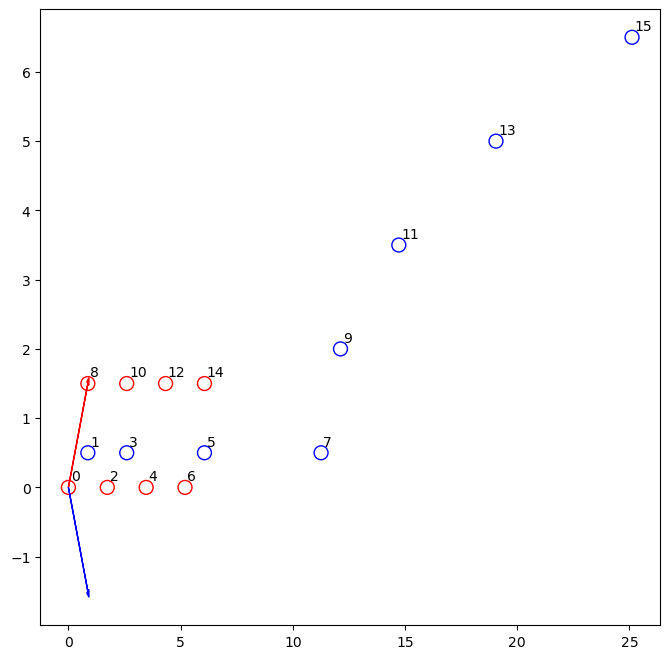

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

a = 1
b = 1
c = 1

Lx = 4
Ly = 2
Ns = 2 * Lx * Ly

_a1 = np.array([np.sqrt(3) * a / 2.0, 3 * a / 2.0, 0])
_a2 = np.array([np.sqrt(3) * a / 2.0, -3 * a / 2.0, 0])
_a3 = np.array([0, 0, c])



coords      = []
move_vector = _a1 - np.array([0, a, 0])
for i in range(Ns):
    # get the unit cell on a square lattic
    x = (i // 2) % Lx
    y = ((i//2) // Lx) % Ly
    
    # from coorditates to position on the lattice
    xy = np.array([0., 0, 0]) if i % 2 == 0 else move_vector
    xy += x * (_a1 + _a2) + y * _a1
    xp, yp = xy[0], xy[1]
    print(xp, yp)
    plt.scatter(xp, yp, color='red' if i % 2 == 0 else 'blue', marker='o', s=100, facecolor='none')
    plt.text(xp + 0.1, yp + 0.1, i)
    
    print("Ns=", i, "-- (x,y)=", x, y)


plt.arrow(0, 0, _a1[0], _a1[1], head_width=0.1, head_length=0.1, fc='r', ec='r')
plt.arrow(0, 0, _a2[0], _a2[1], head_width=0.1, head_length=0.1, fc='b', ec='b')
# plt.arrow(0, 0, _a1[0] - _a2[0], _a1[1] - _a2[1], head_width=0.1, head_length=0.1, fc='g', ec='g')
# plt.arrow(0, 0, _a1[0] + _a2[0], _a1[1] + _a2[1], head_width=0.1, head_length=0.1, fc='y', ec='y')
# plt.arrow(0, 0, -_a1[0] + _a2[0], -_a1[1] + _a2[1], head_width=0.1, head_length=0.1, fc='m', ec='m')
# plt.arrow(0, 0, -_a1[0] - _a2[0], -_a1[1] - _a2[1], head_width=0.1, head_length=0.1, fc='c', ec='c')
